In [1]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, print_progress, add_variable_histogram_summaries, merge, interpolate
from os.path import exists
from glob import glob
import scipy

In [2]:
class Data(object):
    def __init__(self, file_path):
        self.files = glob(file_path)
        self.num_examples = len(self.files)
        
    def next_batch(self, batch_size, batch_id=None):
        if batch_id is None:
            batch_idx = np.random.randint(0, self.num_examples, batch_size)
        else:
            batch_idx = np.arange(batch_id * batch_size, min((batch_id+1) * batch_size, self.num_examples))
            
        images = []
        for i in batch_idx:
            images.append(scipy.misc.imread(self.files[i]) / 127.5 - 1)
        
        return np.stack(images)

data = Data('data/celebB/*.jpg')

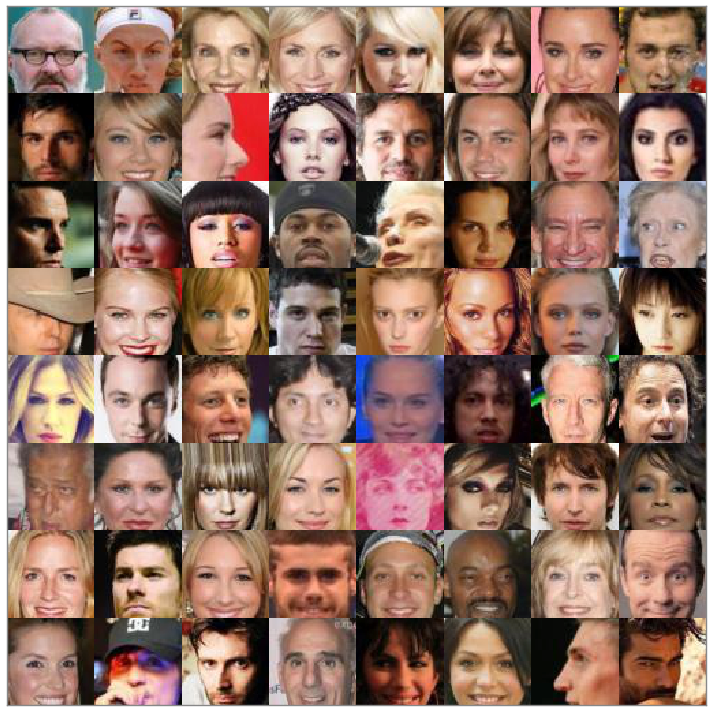

In [3]:
plot_images(merge((data.next_batch(64) + 1) / 2))

In [4]:
def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
              initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]], initializer=tf.random_normal_initializer(stddev=stddev))
        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv
        
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32, tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
        initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

In [7]:
def generator(z, training):
    x_gen = tf.layers.dense(z, 4 * 4 * 512, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    x_gen = tf.reshape(x_gen, (-1, 4, 4, 512))
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 256, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv1')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 128, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv2')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen_vis = tf.layers.conv2d_transpose(x_gen, 64, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv3')
    x_gen = tf.contrib.layers.batch_norm(x_gen_vis, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn4')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 3, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv4')
    return tf.nn.tanh(x_gen), x_gen_vis

In [8]:
def discriminator(img, training):
    p = tf.layers.conv2d(img, 64, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv1')
    p = lrelu(p, 0.2, 'lrelu1')
    
    p = tf.layers.conv2d(p, 128, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv2')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    p = lrelu(p, 0.2, 'lrelu2')
    
    p = tf.layers.conv2d(p, 256, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv3')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    p = lrelu(p, 0.2, 'lrelu3')
    
    p = tf.layers.conv2d(p, 512, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv4')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    p = lrelu(p, 0.2, 'lrelu4')
    
    p = tf.reshape(p, (-1, 4 * 4 * 512))
    p = tf.layers.dense(p, 1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    return p

In [10]:
z_dim = 100

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 64, 64, 3), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    training = tf.placeholder(tf.bool, name='training')
    
with tf.variable_scope('generator'):
    x_gen, x_gen_vis = generator(z, training) 
    
with tf.variable_scope('discriminator'):
    l_x = discriminator(x, training)
    tf.get_variable_scope().reuse_variables()
    l_g = discriminator(x_gen, training)
    
with tf.name_scope('optimizer'):
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.ones_like(l_g)))
    loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_x, labels=tf.ones_like(l_x))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.zeros_like(l_g)))
    optimizer_g = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_g = optimizer_g.compute_gradients(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimize_g = optimizer_g.apply_gradients(grads_g)
    optimizer_d = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_d = optimizer_d.compute_gradients(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))
    optimize_d = optimizer_d.apply_gradients(grads_d)
    
tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
add_variable_histogram_summaries()

for g_v_pair in grads_g:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
for g_v_pair in grads_d:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
summ = tf.summary.merge_all()

saver = tf.train.Saver()

INFO:tensorflow:Summary name generator/fc1/kernel:0 is illegal; using generator/fc1/kernel_0 instead.
INFO:tensorflow:Summary name generator/fc1/bias:0 is illegal; using generator/fc1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn1/beta:0 is illegal; using generator/bn1/beta_0 instead.
INFO:tensorflow:Summary name generator/bn1/gamma:0 is illegal; using generator/bn1/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv1/kernel:0 is illegal; using generator/tconv1/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv1/bias:0 is illegal; using generator/tconv1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn2/beta:0 is illegal; using generator/bn2/beta_0 instead.
INFO:tensorflow:Summary name generator/bn2/gamma:0 is illegal; using generator/bn2/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv2/kernel:0 is illegal; using generator/tconv2/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv2/bias:0 is illegal; using generator/tco

In [8]:
def plot_generated_images(sess, latent=None, save_name=None):
    if latent is None:
        latent = np.random.uniform(-1, 1, (11, z_dim))
        
    generated_images = merge((sess.run(x_gen, feed_dict={z: latent, training:False}) + 1) / 2)
    plot_images(generated_images)
    
    if save_name is not None:
        scipy.misc.imsave('output/celebA/DCGAN-' + save_name + '.jpg', generated_images[0])

In [9]:
batch_size = 64
plot_every = 100

batches_per_epoch = int(data.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('checkpoints/DCGAN-celebA', tf.get_default_graph())
    
    with tf.Session(config=config) as sess:
        if exists('checkpoints/DCGAN-celebA/DCGAN-celebA.data-00000-of-00001'):
            saver.restore(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA')
        else:
            sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            epoch_start_time = time()
            for batch in range(batches_per_epoch):
                x_batch = data.next_batch(batch_size, batch)
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                feed_dict_train = {x: x_batch, z: z_batch, training: True}
                for _ in range(1):
                    sess.run(optimize_d, feed_dict_train)
                for _ in range(2):
                    sess.run(optimize_g, feed_dict_train)

                if (epoch * batches_per_epoch + batch) % 100 == 0:
                    writer.add_summary(sess.run(summ, feed_dict_train), global_step=epoch * batches_per_epoch + batch)
                    
                if batch % plot_every == 0:
                    plot_generated_images(sess)
                print_progress(batch, batches_per_epoch, epoch_start_time)
                
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
            saver.save(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))
    writer.close()

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-celebA/DCGAN-celebA
Random samples


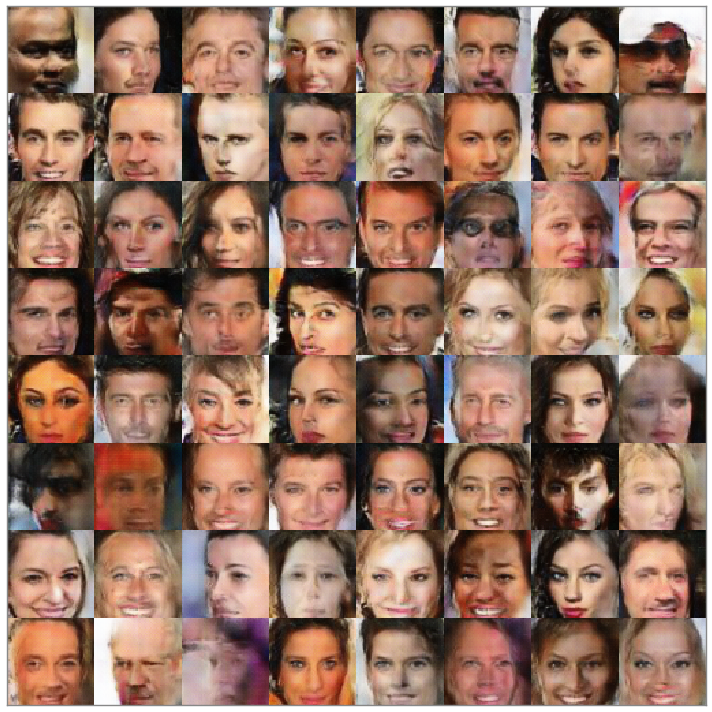

Best samples


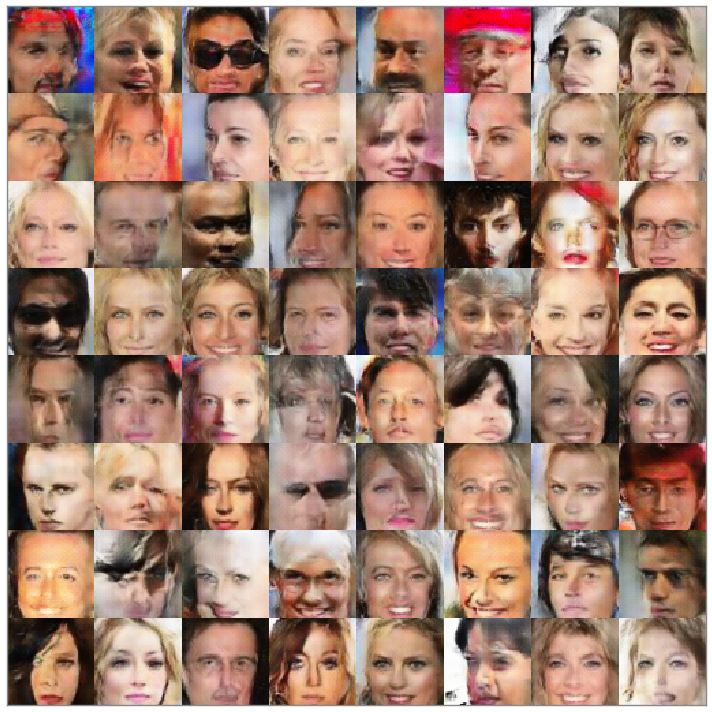

In [10]:
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-celebA/DCGAN-celebA.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA')
    else:
        sess.run(tf.global_variables_initializer())

    latent = np.random.uniform(-1, 1, (640, z_dim))
    disc_prob = sess.run(tf.nn.sigmoid(l_g), feed_dict={z: latent, training:False})
    best_idx = np.argsort(disc_prob[:, 0])[::-1][:64]
    
    print("Random samples")
    plot_generated_images(sess, latent[:64], 'Samples')
    
    print("Best samples")
    plot_generated_images(sess, latent[best_idx], 'Best')

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-celebA/DCGAN-celebA


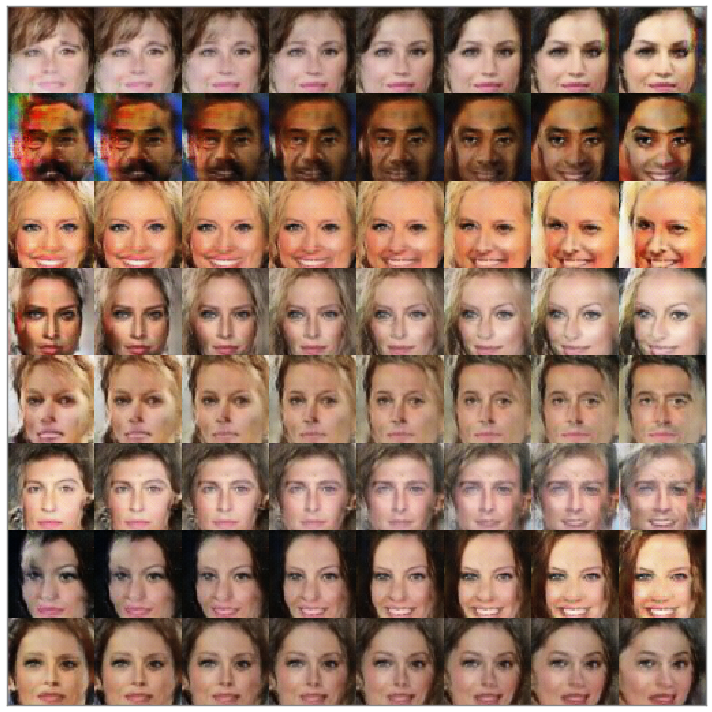

In [11]:
latent_points = []
for _ in range(8):
    latent_points += interpolate(np.random.uniform(-1, 1, (1, z_dim)), np.random.uniform(-1, 1, (1, z_dim)), 8)

with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-celebA/DCGAN-celebA.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA')
    else:
        sess.run(tf.global_variables_initializer())
    
    plot_generated_images(sess, np.vstack(latent_points), 'Interpolation')

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-celebA/DCGAN-celebA


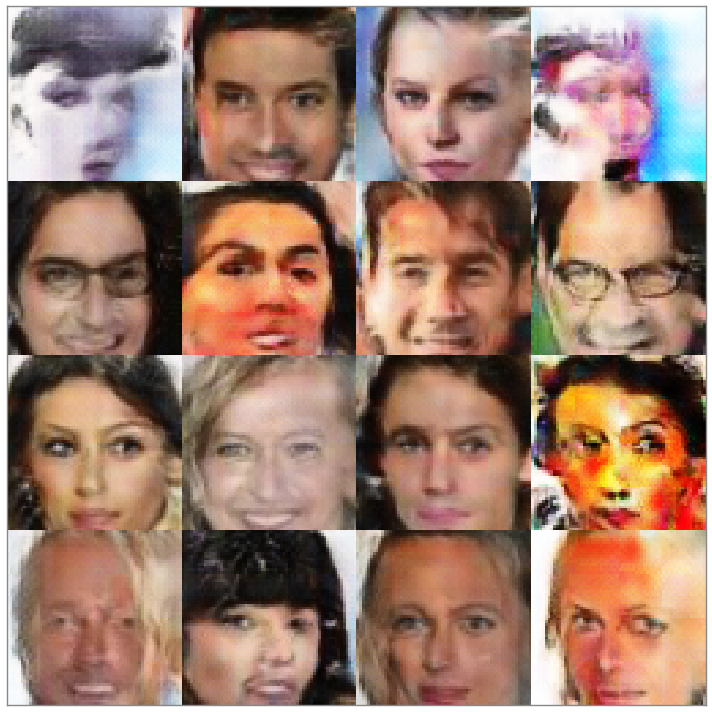

In [13]:
latent_points = []
for _ in range(4):
    for _ in range(3):
        latent_points.append(np.random.uniform(-1, 1, (1, z_dim)))
    latent_points.append(latent_points[-3] - latent_points[-2] + latent_points[-1])

with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-celebA/DCGAN-celebA.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA')
    else:
        sess.run(tf.global_variables_initializer())
    
    plot_generated_images(sess, np.vstack(latent_points), 'Arithmetic')

## Turing Test

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-celebA/DCGAN-celebA


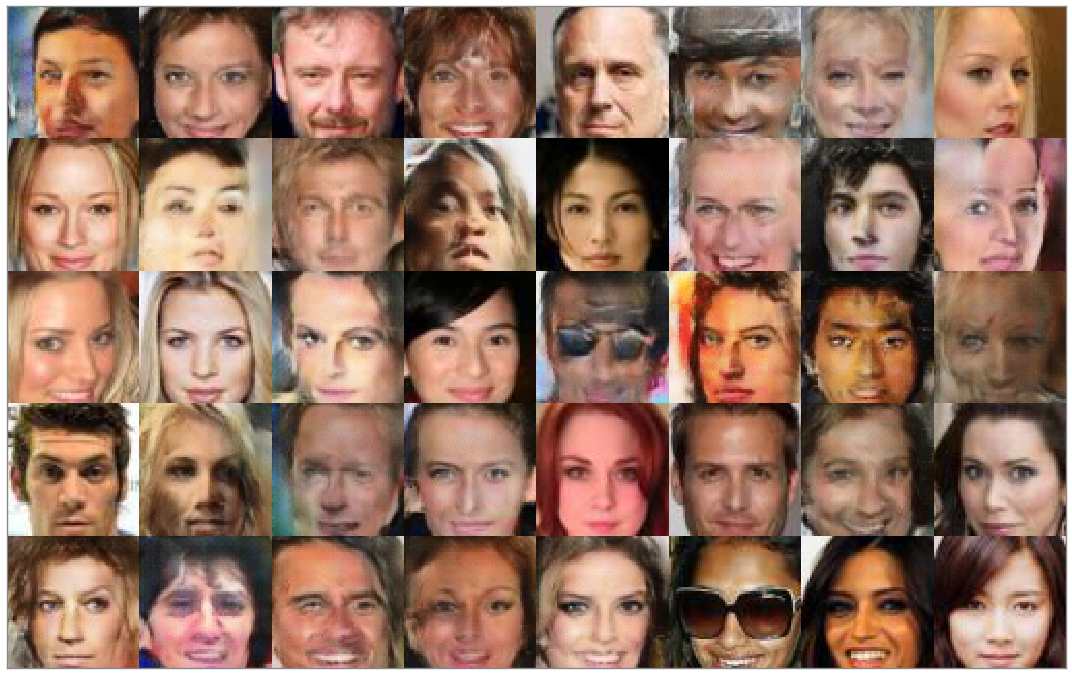

In [89]:
num_points = 40
frac_real = np.random.rand()

num_real = int(frac_real * num_points)
num_fake = num_points - num_real

def print_score(answers, real_answer_list):
    num_real = real_answer_list.count('r')
    num_fake = real_answer_list.count('f')
    num_points = num_real + num_fake
    if len(answers) != num_points:
        print("Answer length needs to be {}. Given {}.".format(num_points, len(answers)))
        return
    
    real_answer_list = list(joint_label[random_mix].flat)
    scores = np.zeros((num_points))
    errors = num_fake
    titles = [''] * num_points
    for i, answer in enumerate(answers):
        if answer == real_answer_list[i]:
            scores[i] = 1
            if answer == 'f':
                errors -= 1
            titles[i] = answer
        elif answer == 'f':
            titles[i] = "Blunder"
        else:
            titles[i] = "Forgery"

    plot_images(joint_data[random_mix], np.asarray(titles))
    print("Score: {}%\nError rate: {}%".format(int(scores.mean() * 100), int(errors / num_fake * 100)))
    
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-celebA/DCGAN-celebA.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA')
    else:
        sess.run(tf.global_variables_initializer())
        
    #real_idx = np.load('output/celebA/DCGAN-Turing-real_idx.npy)
    real_idx = np.random.randint(0, data.num_examples, num_real)
    np.save('output/celebA/DCGAN-Turing-real_idx.npy', real_idx)
    num_real = len(real_idx)
    real_data = data.next_batch(num_real)
    real_label = np.asarray(['r'] * num_real)
    #latent = np.load('output/celebA/DCGAN-Turing-latent.npy')
    latent = np.random.uniform(-1, 1, (num_fake, z_dim))
    np.save('output/celebA/DCGAN-Turing-latent.npy', latent)
    num_fake = len(latent)
        
    fake_data, disc_prob = sess.run([x_gen, tf.nn.sigmoid(l_g)], feed_dict={z: latent, training:False})
    fake_label = np.asarray(['f'] * num_fake)
    joint_data = np.vstack([real_data, fake_data]) * 0.5 + 0.5
    joint_label = np.hstack([real_label, fake_label])
    
    #random_mix = np.load('output/celebA/DCGAN-Turing-random_mix.npy')
    random_mix = np.random.permutation(range(num_points))
    np.save('output/celebA/DCGAN-Turing-random_mix.npy', random_mix)
    plot_images(merge(joint_data[random_mix]))
    scipy.misc.imsave('output/celebA/DCGAN-Turing.jpg', merge(joint_data[random_mix])[0])

In [90]:
my_answers = 'ffrfrffrrfffrfffrrfrffffrffffrfrfffffrrr'

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-celebA/DCGAN-celebA

You human:


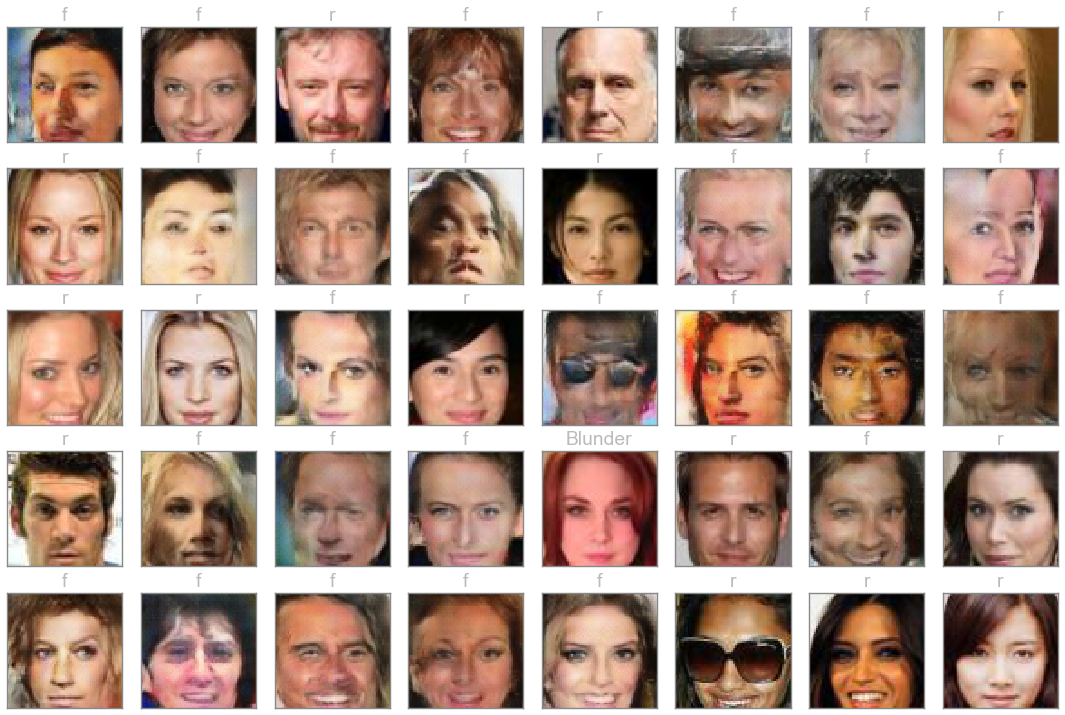

Score: 97%
Error rate: 0%

Discriminator:


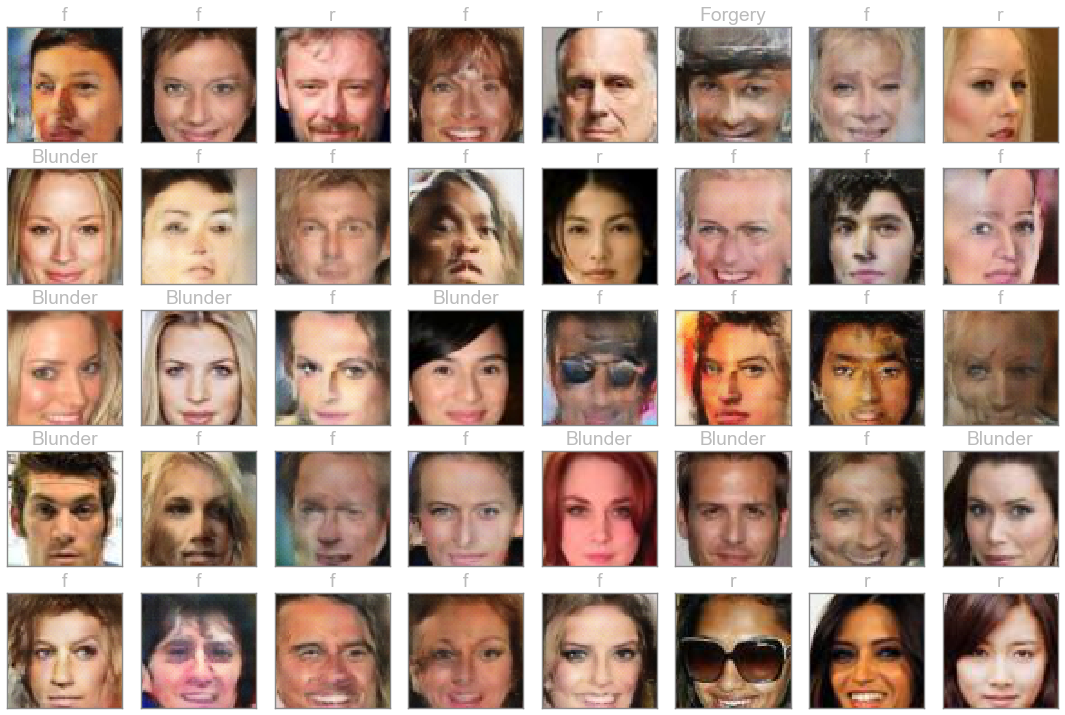

Score: 77%
Error rate: 4%


In [91]:
discriminator_answers = ''
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-celebA/DCGAN-celebA.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-celebA/DCGAN-celebA')
    else:
        sess.run(tf.global_variables_initializer())
        
    real_probs, fake_probs = sess.run([tf.nn.sigmoid(l_x), tf.nn.sigmoid(l_g)], {x: real_data, x_gen: fake_data, training:False})
    joint_probs = np.vstack([real_probs, fake_probs])
    
    for prob in joint_probs[random_mix]:
        if prob >= 0.5:
            discriminator_answers += 'r'
        else:
            discriminator_answers += 'f'

print("\nYou human:")
print_score(my_answers, list(joint_label[random_mix]))
print("\nDiscriminator:")
print_score(discriminator_answers, list(joint_label[random_mix]))